In [386]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from skimage.filters import gabor, sobel, rank
from skimage.feature import hog, local_binary_pattern, ORB
from sklearn.decomposition import PCA
from skimage import io
from skimage.morphology import disk


import cv2 as cv
import os
import matplotlib.pyplot as plt
print('hello')

import pickle
from IPython.display import FileLink


hello


In [2]:
cv2_base_dir = os.path.dirname(os.path.abspath(cv.__file__))
haar_model = os.path.join(cv2_base_dir, 'data/haarcascade_frontalface_default.xml')
haar_data = cv.CascadeClassifier(haar_model)


In [3]:
def gabor_filter(img):
    return gabor(img, frequency=0.8)[0]

In [4]:
def kmeans(img):
    Z = img.reshape(-1)
    Z = np.float32(Z)
    criteria = (cv.TERM_CRITERIA_EPS +
                cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 8
    ret, label, center = cv.kmeans(
        Z, K, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    return res2


In [290]:
def describe(image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = local_binary_pattern(image, 24,
			8, method="uniform")
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, 24 + 3),
			range=(0, 24 + 2))
		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)
		# return the histogram of Local Binary Patterns
		return hist

In [306]:

nomask_edges = []
nomask_hist = []
for dirname, _, filenames in os.walk('H:\Programming\PCD_maskdetection\dataset\without_mask'):
    for filename in filenames:
        detector = ORB(n_keypoints = 8)
        img = cv.imread(os.path.join(dirname, filename))
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # faces = haar_data.detectMultiScale(img, minNeighbors = 5, minSize = (100,100))
        # for x, y, w, h in faces:
        #         face = img[y:y+h, x:x+w]
        #         face = gabor_filter(face)
        #         face = kmeans(face)
        #         face = cv.resize(face, (50, 50))
        face = cv.resize(img, (50, 50))
        face = kmeans(face)
        hist = describe(face)
        edges = sobel(face)

        #edge = sobel(face)
        nomask_edges.append(edges)
        nomask_hist.append(hist)


In [322]:
mask_edges = []
mask_hist = []
for dirname, _, filenames in os.walk('H:\Programming\PCD_maskdetection\dataset\with_mask'):
    for filename in filenames:
            img = cv.imread(os.path.join(dirname, filename))
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            #faces = haar_data.detectMultiScale(img, minNeighbors = 5, minSize = (120,120))
            # for x, y, w, h in faces:
            #         face = img[y:y+h, x:x+w]
            #         face = gabor_filter(face)
            #         face = kmeans(face)
            #         face = cv.resize(face, (50, 50))
            face = cv.resize(img, (50, 50))
            face = kmeans(face)
            hist = describe(face)
            edges = sobel(face)

            #edge = sobel(face)
            mask_edges.append(edges)
            mask_hist.append(hist)




In [349]:
a = np.array(nomask_edges)
a = a.reshape(a.shape[0], 2500)
b = np.array(nomask_hist)

np_nomask = np.concatenate((a,b), axis = 1)
print(np_nomask.shape)

(1930, 2526)


In [352]:
a = np.array(mask_edges)
a = a.reshape(a.shape[0], 2500)
b = np.array(mask_hist)

np_mask = np.concatenate((a,b), axis = 1)
print(np_mask.shape)

(1932, 2526)


In [353]:
print(np_mask.shape)

X = np.r_[np_mask, np_nomask]
labels = np.zeros(X.shape[0])

labels[np_mask.shape[0]:] = 1.0
print(labels[1499])


names = {0: 'Mask', 1: 'Without Mask'}
print(X.shape)



(1932, 2526)
0.0
(3862, 2526)


In [354]:
x_train, x_test, y_train, y_test = train_test_split(X,labels,test_size = 0.25)
print(x_train)


[[5.88235294e-03 1.86016333e-02 1.31533410e-02 ... 1.44000000e-02
  1.25200000e-01 4.69600000e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.60000000e-02
  2.44000000e-02 5.44800000e-01]
 [2.45326947e-18 2.45326947e-18 2.45326947e-18 ... 2.16000000e-02
  1.80000000e-02 4.13600000e-01]
 ...
 [1.96261557e-17 1.96261557e-17 1.96261557e-17 ... 1.76000000e-02
  2.32000000e-02 5.66000000e-01]
 [0.00000000e+00 8.98811638e-02 1.27111161e-01 ... 2.64000000e-02
  4.00000000e-02 6.31200000e-01]
 [1.96261557e-17 1.96261557e-17 1.96261557e-17 ... 2.12000000e-02
  4.40000000e-02 6.11600000e-01]]


In [355]:
svm = SVC(C = 1, break_ties = False, cache_size = 200, class_weight = 'balanced', 
          coef0 = 0.0, decision_function_shape = 'ovr', degree = 3, gamma = 'scale',
         kernel = 'rbf', max_iter = -1, probability = False, random_state = None, 
          shrinking = True, tol = 0.001, verbose =False )
svm.fit(x_train, y_train)


SVC(C=1, class_weight='balanced')

In [267]:
nn = MLPClassifier()

nn.fit(x_train, y_train)

MLPClassifier()

In [356]:

y_pred = svm.predict(x_test)
print('svm', accuracy_score(y_test, y_pred))




svm 0.8385093167701864


In [118]:
print(y_pred)

[0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0.
 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1.

In [429]:
filename = 'model10.sav'
os.chdir('H:\Programming\PCD_maskdetection')

pickle.dump(svm, open(filename, 'wb'))



(2526,)
(1, 2526)
Mask


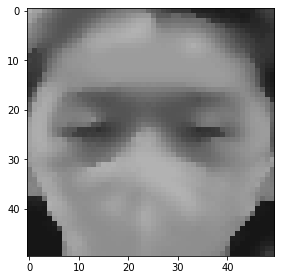

In [428]:
filename = "dataset/with_mask/71.jpg"
img = cv.imread(filename)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
face = cv.resize(img, (50, 50))
face =kmeans(face)
face = rank.mean_bilateral(
    face, footprint=disk(2), s0=50, s1=50
)

edges = np.array(sobel(face))
hist = np.array(describe(face))
io.imshow(face)

edges = edges.reshape(2500)
test = np.concatenate((edges,hist), axis =0)
print(test.shape)
test = test.reshape(1,-1)
print(test.shape)
print(names[int(svm.predict(test))])
